In [3]:
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install datasets torchmetrics gradio kaggle typing-extensions

In [4]:
from google.colab import drive
import shutil
import os
drive.mount('/content/drive', force_remount=True)

source_folder_path = '/content/drive/My Drive/fac/master/bigData'
destination_folder_path = '/content/bigData'

shutil.copytree(source_folder_path, destination_folder_path)
directory_path = '/content/bigData/big_data_project'

os.chdir(directory_path)

Mounted at /content/drive


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
import sys
sys.path.append('/content/drive/My Drive/fac/master/bigData/big_data_project')

from data_pipeline import get_dataloaders, text_preprocess, isot_clean

checkpoint_path = '../../drive/My Drive/fac/master/bigData/trained_model/'
trainset_path = 'drive/My Drive/fac/master/bigData/big_data_project/train.csv'
testset_path = '../../drive/My Drive/fac/master/bigData/big_data_project/test.csv'

(train_loader, val_loader, test_loader), (tokenizer, vocab) = get_dataloaders(dataset_id="fake_news", model="bert")

def inference(model, input_str, max_len=512, isot=False, device="cpu", processor=None):
    if isot:
        input_str = isot_clean(input_str)
    # tokenizer, vocab = processor
    preprocessed = text_preprocess(input_str)
    token_ids = vocab(tokenizer(preprocessed))
    if not token_ids:
        return np.array([0.5, 0.5])
    input_ids = torch.tensor(token_ids[:max_len]).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_ids).squeeze().detach().cpu().item()

    return np.array([1 - prediction, prediction])

###################################################################################################

class BERTModel(nn.Module):
    def __init__(self, num_labels):
        super(BERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).logits

model = BERTModel(num_labels=2)  # Assuming binary classification, adjust num_labels accordingly

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_labels, train_preds = [], []
    train_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        inputs = batch[0]
        labels = batch[1].to(device)

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predictions.cpu().numpy())

        train_loss += loss.item()

    # Average training loss
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_labels, val_preds = [], []
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0]
            labels = batch[1].to(device)

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    # Average validation loss
    val_loss /= len(val_loader)

    train_accuracy = accuracy_score(train_labels, train_preds)
    val_accuracy = accuracy_score(val_labels, val_preds)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_full_path = checkpoint_path + "bert_fake_news.tar"
        model_config = {
            "num_labels" : 2
        }
        torch.save(
            {
                "epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "model_config": model_config,
                "optimizer_state_dict": optimizer.state_dict()
            },
            checkpoint_full_path
        )

        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, '
          f'Patience Counter: {patience_counter}')

    # Check for early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
        break


# # Testing
# model.eval()
# test_labels, test_preds = [], []
# with torch.no_grad():
#     for batch in test_loader:
#         inputs = batch[0]
#         labels = batch[1].to(device)

#         input_ids = inputs['input_ids'].to(device)
#         attention_mask = inputs['attention_mask'].to(device)

#         logits = model(input_ids=input_ids, attention_mask=attention_mask)
#         predictions = torch.argmax(logits, dim=1)

#         test_labels.extend(labels.cpu().numpy())
#         test_preds.extend(predictions.cpu().numpy())

# test_accuracy = accuracy_score(test_labels, test_preds)
# print(f'Test Accuracy: {test_accuracy:.4f}')

model.eval()
# results = []

submission_ids = []
submission_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        text, _, _, ids = batch
        text = text.to(device)
        submission_ids.extend(ids.tolist())
        predictions = model(text).round().int().squeeze().detach().cpu().tolist()
        submission_labels.extend(predictions)

df_test = pd.read_csv(testset_path)
for idx in df_test["id"]:
     if idx not in submission_ids:
        submission_ids.append(idx)
        submission_labels.append(1)

submission_df = pd.DataFrame.from_dict({"id": submission_ids, "label": submission_labels})
submission_df.to_csv("submission.csv",index=False)

# for batch in test_loader:
#     inputs = batch[0]
#     print(batch)
#
#     input_ids = inputs['input_ids'].to(device)
#     attention_mask = inputs['attention_mask'].to(device)

#     logits = model(input_ids=input_ids, attention_mask=attention_mask)
#     predictions = torch.argmax(logits, dim=1)

#     for id, text, label in zip(batch[2], batch[0], predictions.cpu().numpy()):
#         results.append({'id': id.item(), 'text': text, 'predicted_label': label.item()})

# result_df = pd.DataFrame(results)
# result_df.to_csv('predictions.csv', index=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.2113, Training Accuracy: 0.9122, Validation Loss: 0.0718, Validation Accuracy: 0.9738, Patience Counter: 0
Epoch 2/5, Training Loss: 0.0606, Training Accuracy: 0.9797, Validation Loss: 0.0798, Validation Accuracy: 0.9767, Patience Counter: 1
Epoch 3/5, Training Loss: 0.0296, Training Accuracy: 0.9902, Validation Loss: 0.0529, Validation Accuracy: 0.9845, Patience Counter: 0
Epoch 4/5, Training Loss: 0.0197, Training Accuracy: 0.9934, Validation Loss: 0.0562, Validation Accuracy: 0.9874, Patience Counter: 1
Epoch 5/5, Training Loss: 0.0087, Training Accuracy: 0.9973, Validation Loss: 0.0657, Validation Accuracy: 0.9835, Patience Counter: 2
Early stopping at epoch 5 due to no improvement in validation loss.


ValueError: not enough values to unpack (expected 4, got 3)

In [18]:
model.eval()
results = []
pred = []
for batch in test_loader:
    inputs = batch[0]

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    logits = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(logits, dim=1)

    for id, label in zip(batch[2], predictions.cpu().numpy()):
        results.append({'id': id.item(), 'label': label.item()})
        pred.append(label.item())
    # result_df = pd.DataFrame({'id': batch[2], 'predicted_label': predictions.cpu().numpy()})
print(len(pred))
result_df = pd.DataFrame(results)
result_df.to_csv('predictions.csv', index=False)
# result_df.to_csv('result_predictions.csv', index=False)


5110


                                                       0  1      2
0      {'input_ids': [tensor(101), tensor(2215), tens...  0   6969
1      {'input_ids': [tensor(101), tensor(1014), tens...  1   4013
2      {'input_ids': [tensor(101), tensor(3487), tens...  0   7071
3      {'input_ids': [tensor(101), tensor(2355), tens...  1   9478
4      {'input_ids': [tensor(101), tensor(6877), tens...  0   1901
...                                                  ... ..    ...
19318  {'input_ids': [tensor(101), tensor(2175), tens...  1  11284
19319  {'input_ids': [tensor(101), tensor(3422), tens...  1  11964
19320  {'input_ids': [tensor(101), tensor(1999), tens...  0   5390
19321  {'input_ids': [tensor(101), tensor(2845), tens...  1    860
19322  {'input_ids': [tensor(101), tensor(2002), tens...  1  15795

[19323 rows x 3 columns]


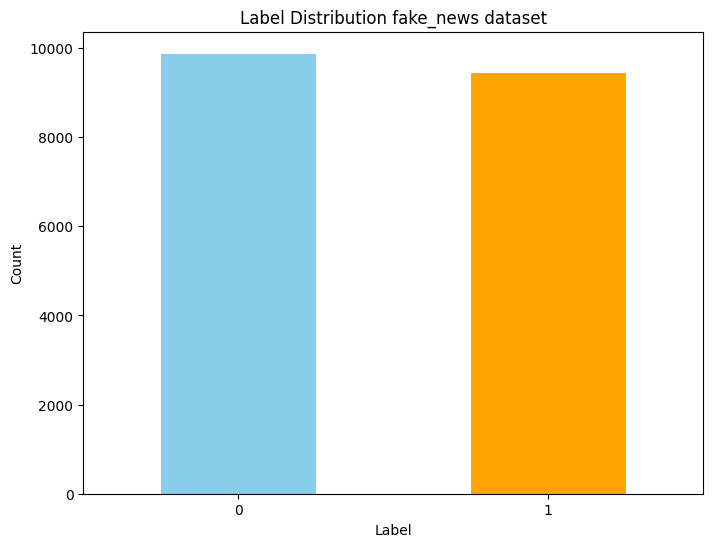

In [7]:
# plots
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/content/drive/My Drive/fac/master/bigData/big_data_project')

from data_pipeline import get_dataloaders, text_preprocess, isot_clean

checkpoint_path = '../../drive/My Drive/fac/master/bigData/trained_model/'

(train_loader, val_loader, test_loader), (tokenizer, vocab) = get_dataloaders(dataset_id="fake_news", model="bert")

train_dataset = train_loader.dataset
data = [sample for sample in train_dataset]

df = pd.DataFrame(data)

inputs = df[0].tolist()
labels = df[1].tolist()
df = df.rename(columns={0: 'input_data', 1: 'label', 2: 'id'})

# Plotting label distribution
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution fake_news dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [8]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd

import sys
sys.path.append('/content/drive/My Drive/fac/master/bigData/big_data_project')

from data_pipeline import get_dataloaders, text_preprocess, isot_clean

checkpoint_path = '../../drive/My Drive/fac/master/bigData/trained_model/'

(train_loader, val_loader, test_loader), (tokenizer, vocab) = get_dataloaders(dataset_id="fake_news", model="bert")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
checkpoint = torch.load(checkpoint_path + 'bert_fake_news.tar')

adjusted_state_dict = {key.replace('bert.', ''): value for key, value in checkpoint['model_state_dict'].items()}

model.load_state_dict(adjusted_state_dict)
model.eval()

results = []

for batch in test_loader:
    inputs = batch[0]

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    logits = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(logits, dim=1)

    for id, text, label in zip(batch[2], batch[0]['text'], predictions.cpu().numpy()):
        results.append({'id': id.item(), 'text': text, 'predicted_label': label.item()})

result_df = pd.DataFrame(results)
result_df.to_csv('predictions.csv', index=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
	Missing key(s) in state_dict: "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias", "bert.pooler.dense.weight", "bert.pooler.dense.bias". 
	Unexpected key(s) in state_dict: "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "encoder.layer.0.attention.self.query.weight", "encoder.layer.0.attention.self.query.bias", "encoder.layer.0.attention.self.key.weight", "encoder.layer.0.attention.self.key.bias", "encoder.layer.0.attention.self.value.weight", "encoder.layer.0.attention.self.value.bias", "encoder.layer.0.attention.output.dense.weight", "encoder.layer.0.attention.output.dense.bias", "encoder.layer.0.attention.output.LayerNorm.weight", "encoder.layer.0.attention.output.LayerNorm.bias", "encoder.layer.0.intermediate.dense.weight", "encoder.layer.0.intermediate.dense.bias", "encoder.layer.0.output.dense.weight", "encoder.layer.0.output.dense.bias", "encoder.layer.0.output.LayerNorm.weight", "encoder.layer.0.output.LayerNorm.bias", "encoder.layer.1.attention.self.query.weight", "encoder.layer.1.attention.self.query.bias", "encoder.layer.1.attention.self.key.weight", "encoder.layer.1.attention.self.key.bias", "encoder.layer.1.attention.self.value.weight", "encoder.layer.1.attention.self.value.bias", "encoder.layer.1.attention.output.dense.weight", "encoder.layer.1.attention.output.dense.bias", "encoder.layer.1.attention.output.LayerNorm.weight", "encoder.layer.1.attention.output.LayerNorm.bias", "encoder.layer.1.intermediate.dense.weight", "encoder.layer.1.intermediate.dense.bias", "encoder.layer.1.output.dense.weight", "encoder.layer.1.output.dense.bias", "encoder.layer.1.output.LayerNorm.weight", "encoder.layer.1.output.LayerNorm.bias", "encoder.layer.2.attention.self.query.weight", "encoder.layer.2.attention.self.query.bias", "encoder.layer.2.attention.self.key.weight", "encoder.layer.2.attention.self.key.bias", "encoder.layer.2.attention.self.value.weight", "encoder.layer.2.attention.self.value.bias", "encoder.layer.2.attention.output.dense.weight", "encoder.layer.2.attention.output.dense.bias", "encoder.layer.2.attention.output.LayerNorm.weight", "encoder.layer.2.attention.output.LayerNorm.bias", "encoder.layer.2.intermediate.dense.weight", "encoder.layer.2.intermediate.dense.bias", "encoder.layer.2.output.dense.weight", "encoder.layer.2.output.dense.bias", "encoder.layer.2.output.LayerNorm.weight", "encoder.layer.2.output.LayerNorm.bias", "encoder.layer.3.attention.self.query.weight", "encoder.layer.3.attention.self.query.bias", "encoder.layer.3.attention.self.key.weight", "encoder.layer.3.attention.self.key.bias", "encoder.layer.3.attention.self.value.weight", "encoder.layer.3.attention.self.value.bias", "encoder.layer.3.attention.output.dense.weight", "encoder.layer.3.attention.output.dense.bias", "encoder.layer.3.attention.output.LayerNorm.weight", "encoder.layer.3.attention.output.LayerNorm.bias", "encoder.layer.3.intermediate.dense.weight", "encoder.layer.3.intermediate.dense.bias", "encoder.layer.3.output.dense.weight", "encoder.layer.3.output.dense.bias", "encoder.layer.3.output.LayerNorm.weight", "encoder.layer.3.output.LayerNorm.bias", "encoder.layer.4.attention.self.query.weight", "encoder.layer.4.attention.self.query.bias", "encoder.layer.4.attention.self.key.weight", "encoder.layer.4.attention.self.key.bias", "encoder.layer.4.attention.self.value.weight", "encoder.layer.4.attention.self.value.bias", "encoder.layer.4.attention.output.dense.weight", "encoder.layer.4.attention.output.dense.bias", "encoder.layer.4.attention.output.LayerNorm.weight", "encoder.layer.4.attention.output.LayerNorm.bias", "encoder.layer.4.intermediate.dense.weight", "encoder.layer.4.intermediate.dense.bias", "encoder.layer.4.output.dense.weight", "encoder.layer.4.output.dense.bias", "encoder.layer.4.output.LayerNorm.weight", "encoder.layer.4.output.LayerNorm.bias", "encoder.layer.5.attention.self.query.weight", "encoder.layer.5.attention.self.query.bias", "encoder.layer.5.attention.self.key.weight", "encoder.layer.5.attention.self.key.bias", "encoder.layer.5.attention.self.value.weight", "encoder.layer.5.attention.self.value.bias", "encoder.layer.5.attention.output.dense.weight", "encoder.layer.5.attention.output.dense.bias", "encoder.layer.5.attention.output.LayerNorm.weight", "encoder.layer.5.attention.output.LayerNorm.bias", "encoder.layer.5.intermediate.dense.weight", "encoder.layer.5.intermediate.dense.bias", "encoder.layer.5.output.dense.weight", "encoder.layer.5.output.dense.bias", "encoder.layer.5.output.LayerNorm.weight", "encoder.layer.5.output.LayerNorm.bias", "encoder.layer.6.attention.self.query.weight", "encoder.layer.6.attention.self.query.bias", "encoder.layer.6.attention.self.key.weight", "encoder.layer.6.attention.self.key.bias", "encoder.layer.6.attention.self.value.weight", "encoder.layer.6.attention.self.value.bias", "encoder.layer.6.attention.output.dense.weight", "encoder.layer.6.attention.output.dense.bias", "encoder.layer.6.attention.output.LayerNorm.weight", "encoder.layer.6.attention.output.LayerNorm.bias", "encoder.layer.6.intermediate.dense.weight", "encoder.layer.6.intermediate.dense.bias", "encoder.layer.6.output.dense.weight", "encoder.layer.6.output.dense.bias", "encoder.layer.6.output.LayerNorm.weight", "encoder.layer.6.output.LayerNorm.bias", "encoder.layer.7.attention.self.query.weight", "encoder.layer.7.attention.self.query.bias", "encoder.layer.7.attention.self.key.weight", "encoder.layer.7.attention.self.key.bias", "encoder.layer.7.attention.self.value.weight", "encoder.layer.7.attention.self.value.bias", "encoder.layer.7.attention.output.dense.weight", "encoder.layer.7.attention.output.dense.bias", "encoder.layer.7.attention.output.LayerNorm.weight", "encoder.layer.7.attention.output.LayerNorm.bias", "encoder.layer.7.intermediate.dense.weight", "encoder.layer.7.intermediate.dense.bias", "encoder.layer.7.output.dense.weight", "encoder.layer.7.output.dense.bias", "encoder.layer.7.output.LayerNorm.weight", "encoder.layer.7.output.LayerNorm.bias", "encoder.layer.8.attention.self.query.weight", "encoder.layer.8.attention.self.query.bias", "encoder.layer.8.attention.self.key.weight", "encoder.layer.8.attention.self.key.bias", "encoder.layer.8.attention.self.value.weight", "encoder.layer.8.attention.self.value.bias", "encoder.layer.8.attention.output.dense.weight", "encoder.layer.8.attention.output.dense.bias", "encoder.layer.8.attention.output.LayerNorm.weight", "encoder.layer.8.attention.output.LayerNorm.bias", "encoder.layer.8.intermediate.dense.weight", "encoder.layer.8.intermediate.dense.bias", "encoder.layer.8.output.dense.weight", "encoder.layer.8.output.dense.bias", "encoder.layer.8.output.LayerNorm.weight", "encoder.layer.8.output.LayerNorm.bias", "encoder.layer.9.attention.self.query.weight", "encoder.layer.9.attention.self.query.bias", "encoder.layer.9.attention.self.key.weight", "encoder.layer.9.attention.self.key.bias", "encoder.layer.9.attention.self.value.weight", "encoder.layer.9.attention.self.value.bias", "encoder.layer.9.attention.output.dense.weight", "encoder.layer.9.attention.output.dense.bias", "encoder.layer.9.attention.output.LayerNorm.weight", "encoder.layer.9.attention.output.LayerNorm.bias", "encoder.layer.9.intermediate.dense.weight", "encoder.layer.9.intermediate.dense.bias", "encoder.layer.9.output.dense.weight", "encoder.layer.9.output.dense.bias", "encoder.layer.9.output.LayerNorm.weight", "encoder.layer.9.output.LayerNorm.bias", "encoder.layer.10.attention.self.query.weight", "encoder.layer.10.attention.self.query.bias", "encoder.layer.10.attention.self.key.weight", "encoder.layer.10.attention.self.key.bias", "encoder.layer.10.attention.self.value.weight", "encoder.layer.10.attention.self.value.bias", "encoder.layer.10.attention.output.dense.weight", "encoder.layer.10.attention.output.dense.bias", "encoder.layer.10.attention.output.LayerNorm.weight", "encoder.layer.10.attention.output.LayerNorm.bias", "encoder.layer.10.intermediate.dense.weight", "encoder.layer.10.intermediate.dense.bias", "encoder.layer.10.output.dense.weight", "encoder.layer.10.output.dense.bias", "encoder.layer.10.output.LayerNorm.weight", "encoder.layer.10.output.LayerNorm.bias", "encoder.layer.11.attention.self.query.weight", "encoder.layer.11.attention.self.query.bias", "encoder.layer.11.attention.self.key.weight", "encoder.layer.11.attention.self.key.bias", "encoder.layer.11.attention.self.value.weight", "encoder.layer.11.attention.self.value.bias", "encoder.layer.11.attention.output.dense.weight", "encoder.layer.11.attention.output.dense.bias", "encoder.layer.11.attention.output.LayerNorm.weight", "encoder.layer.11.attention.output.LayerNorm.bias", "encoder.layer.11.intermediate.dense.weight", "encoder.layer.11.intermediate.dense.bias", "encoder.layer.11.output.dense.weight", "encoder.layer.11.output.dense.bias", "encoder.layer.11.output.LayerNorm.weight", "encoder.layer.11.output.LayerNorm.bias", "pooler.dense.weight", "pooler.dense.bias". 